Copying over some of the Eps ind stuff and using to develop prepare_iue.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d



import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse

from astropy.units import cds
cds.enable()

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
# path = '/media/david/2tb_ext_hd/hddata/hwo/data/iue/'


In [3]:
# mxlos = glob.glob('{}/HIP_108870/*mxlo.gz'.format(path))
# swls = []
# lwls = []
# for spec in mxlos:
#     if spec != '/media/david/2tb_ext_hd/hddata/hwo/data/iue/HIP_108870/lwr10686.mxlo.gz':
#         if os.path.split(spec)[1][0:2] == 'sw':
#             swls.append(spec)
#         elif os.path.split(spec)[1][0:2] == 'lw':
#             lwls.append(spec)

# print(swls)

In [4]:
# from scipy import stats
# from astropy.stats import poisson_conf_interval
# from specutils import Spectrum1D
# from specutils.manipulation import FluxConservingResampler
# from astropy.nddata import StdDevUncertainty



# def coadd_iue(spectra, dq_cut=0, rebin=True, rebin_pix=2):
#     """
#     Coadds IUE spectra using throughput weighting and dq masking. Bins by factor two by default
#     """
#     fluxes = []
#     dqs = []
#     waves = []
#     counts = []
#     nets = []
#     for spec in spectra:
#         hdul = fits.open(spec)
#         hdr = hdul[0].header
#         data = hdul[1].data
#         hdul.close()
#         fluxes.append(data[0]['FLUX'])
#         dqs.append(-1*data[0]['QUALITY'])
#         counts.append(data[0]['NET']+data[0]['BACKGROUND']) 
#         nets.append(data[0]['NET'])
#         w = np.array([data[0]['WAVELENGTH']+ data[0]['DELTAW']*i for i in range(data[0]['NPOINTS'])])
#         waves.append(w)

#     #mask and coadd data, weighted by throughput
#     mask = np.array(dqs) > dq_cut
#     fluxes = np.ma.array(fluxes, mask = mask)
#     nets = np.ma.array(nets, mask = mask)
#     coadd_flux = np.ma.average(fluxes,weights=nets/fluxes, axis=0).data

#     #sum all counts and calculate S/N
#     sumcounts = np.ma.sum(np.ma.array(counts, mask=mask), axis=0)#.data 
#     sumnets = np.ma.sum(np.ma.array(nets, mask=mask), axis=0)#.data 
#     coadd_error = (sumcounts**0.5 / sumnets) * coadd_flux #/ np.sum(exptimes)
#     n = 0
#     while np.min(coadd_error) < 0.0 and n < 100: #removing negative error values and replacing them with adjacent points. N count stops infinate loop
#         new_error = np.copy(coadd_error)
#         for i in range(len(new_error)):
#             if new_error[i] < 0.0:
#                 new_error[i] = np.mean((new_error[i-1], new_error[i-1]))
#         coadd_error = new_error
#         n +=1
                                    
#     # test without the dq masking
#     # coadd_flux = np.average(fluxes, weights=1/np.array(throughputs), axis=0)
#     # sumcounts = np.sum(np.array(counts), axis=0)
#     # coadd_error = np.sqrt(sumcounts) / sumcounts * coadd_flux #/ np.sum(exptimes)


#     wavelength = stats.mode(waves).mode # wavelength arrays are near identical so just use the mode in each case. Experiment with uniform grid?

#     # rebinning 
#     if rebin:
#         w0, w1 = wavelength[0], wavelength[-1]
#         dw = np.median(np.diff(wavelength)) *rebin_pix
#         new_wavelength = np.arange(w0, w1, dw)
#         fluxcon = FluxConservingResampler(extrapolation_treatment='zero_fill')
#         input_spec = Spectrum1D(spectral_axis=wavelength*u.AA, 
#                                 flux=coadd_flux*u.erg/u.s/u.cm**2/u.AA ,
#                                 uncertainty= StdDevUncertainty(coadd_error))
#         new_spec_fluxcon = fluxcon(input_spec, new_wavelength*u.AA)
#         wavelength = (new_spec_fluxcon.spectral_axis.value)
#         coadd_flux = (new_spec_fluxcon.flux.value)
#         coadd_error = (1/(new_spec_fluxcon.uncertainty.array**0.5))
       
        
    
    
#     return wavelength, coadd_flux, coadd_error
    
# fig, ax = plt.subplots()

# w2, f2, e2 = coadd_iue(lwls)

# # fig, ax = plt.subplots()

# ax.step(w2, f2, where='mid')
# ax.step(w2, e2, where='mid')

# # print(np.median(f2/e2))
# # ax.step(w2, f2/e2)

# # f2i = convolve(f2, Box1DKernel(3))
# # ax.step(w2, f2i, where='mid')
# # ax.step(w2, e2, where='mid')

# # ax.step(w2, f2i/e2,  where='mid')

# # for spec in swls:
# #     data = fits.getdata(spec, 1)
# #     w2 = np.array([data[0]['WAVELENGTH']+ data[0]['DELTAW']*i for i in range(data[0]['NPOINTS'])])
#     # print(w2[-1])
#     # plt.plot(np.arange(data[0]['NPOINTS']), w2, alpha=0.5)
    
#     # print(data['WAVELENGTH'], data['DELTAW'], data['NPOINTS'])
#         # mxlos

# #darn will have to interpolate onto a common grid. Differences are so small, better to ignore them.


# #if os.path.split(spec)[1][0:2] == 'sw':
# # ax.step(w_sw, f_sw, where='mid')
# # ax.step(w_sw, e_sw, where='mid')
# # ax.step(w_lw, f_lw, where='mid', c= plt.cm.plasma(cols[2]))
# # ax.step(w_sw, f_sw/e_sw)
# # ax.set_ylim(-1, 10)
# # ax.set_yscale('log')


In [5]:
# hdr = fits.getheader(mxlos[0])

In [6]:
# start = hdr['LJD-OBS']*cds.JD
# print(start)

In [7]:
# start.to(cds.MJD)

In [8]:
import importlib
import prepare_iue


ValueError: 'count' did not parse as unit: At col 0, count is not a valid unit.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html

In [ ]:
importlib.reload(prepare_iue)
mxlopath = '/media/david/2tb_ext_hd/hddata/hwo/data/iue/HIP_108870/use_mxlos/'
savepath = 'draft_hlsp/eps_ind/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_iue.make_iue_spectrum(mxlopath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'eps_Ind')

X-ray, hopfully can modify/use prepare xmm for eRosita

In [ ]:
for ext in [1, 2,3]:
    print(hdul[ext].data.names)

In [ ]:
hdr = hdul[0].header
hdr

In [ ]:
# hdr.append(('mos1_FILTER', 'Medium'))
# hdr.append(('mos2_FILTER', 'Medium'))
# hdr.append(('pn_FILTER', 'Medium'))
# hdr.append(('pn_DURATION', 18500))
# hdr.append(('pn_DATE-OBS', '2023-06-18 18:41:18'))
# hdr.append(('pn_DATE-END','2023-06-18 23:49:38' ))
# hdr.append(('OBS_ID', '0892000301'))
# hdr

Erosita metadata is a mess, wait to chat with Christain at meeting.

In [ ]:
hdul.close()

In [ ]:
files = ['k2-18.ipynb', 'LICENSE', 'notreal']
truth = [os.path.exists(file) for file in files]
if all(truth):
    print('yes')
else:
    print('no')

In [25]:

def sort_ghrs(inpath):
    """
    Takes a path to where some ghrs files are stored, sorts them by grating and checks that they have wavelength, flux, error and dq arrays  
    """
    grating_collection = {}
    c0f_list = glob.glob('{}*c0f.fits'.format(inpath))
    # roots = []
    for c0f in c0f_list:
        hdr = fits.getheader(c0f, 0)
        rootname = hdr['ROOTNAME']
        cfs = ['{}/{}_c1f.fits'.format(inpath, rootname.lower()), '{}/{}_c2f.fits'.format(inpath, rootname.lower()), '{}/{}_cqf.fits'.format(inpath, rootname.lower())]
        if all([os.path.exists(cf) for cf in cfs]):
            grating = hdr['GRATING']
            if grating not in grating_collection.keys():
                grating_collection[grating] = [rootname]
            else:
                grating_collection[grating].append(rootname)

    return grating_collection

inpath = '/media/david/2tb_ext_hd/hddata/hwo/data/hst/HIP-108870/ghrs/'
print(sort_ghrs(inpath))
gdsort = sort_ghrs('/media/david/2tb_ext_hd/hddata/ghrs_test/gd394/')
print(sort_ghrs('/media/david/2tb_ext_hd/hddata/ghrs_test/gd394/'))

{'ECH-A': ['Z2H00308M']}
{'G160M': ['Z0YE0A08M', 'Z0YE0A0AM', 'Z0YE0A0CM']}


In [ ]:
(57.024*u.min).to(u.s)

In [ ]:
 3291.200 /766.656

In [43]:
testdict=dict(w=[], f=[], e=[])
print(testdict)
testdict['w'].append([1,3,4])
print(testdict)
print(testdict['w'][0])

testdict['w'].append([7,8,9])
# print(testdict)
testdict['w'] = np.sum(testdict['w'], axis=1)
print(testdict)

testdict['w'] = testdict['w'][0]
print(testdict)

print(testdict.keys())
[print(key) for key in testdict.keys()]

{'w': [], 'f': [], 'e': []}
{'w': [[1, 3, 4]], 'f': [], 'e': []}
[1, 3, 4]
{'w': array([ 8, 24]), 'f': [], 'e': []}
{'w': 8, 'f': [], 'e': []}
dict_keys(['w', 'f', 'e'])
w
f
e


[None, None, None]

In [35]:
def combine_ghrs(inpath, rootnames):
    """
    Coadds a collection of ghrs spectra from the same grating. Input is a list of rootnames that should have already been sorted by grating, and checked to see if the avaialble
    wavelength, flux, error and dq files exist.

    """
    if len(rootnames) > 0:
        spectrum = dict(WAVELENGTH=[], WAVELENGTH0=[], WAVELENGTH1=[], FLUX=[], ERROR=[], DQ=[], EXPTIME=[], EXPSTART=[], EXPEND=[])
        c0f_list = np.array(['{}{}_c0f.fits'.format(inpath, rootname.lower()) for rootname in rootnames])
        for rootname in rootnames:
            print(rootname)
            hdr = fits.getheader('{}/{}_c0f.fits'.format(inpath, rootname.lower()), 0)
            wavelength_arrays = fits.getdata('{}/{}_c0f.fits'.format(inpath, rootname.lower()), 0)
            flux_arrays = fits.getdata('{}/{}_c1f.fits'.format(inpath, rootname.lower()), 0)
            error_arrays = fits.getdata('{}/{}_c2f.fits'.format(inpath, rootname.lower()), 0)
            dq_arrays = fits.getdata('{}/{}_cqf.fits'.format(inpath, rootname.lower()), 0)
            # spectrum['WAVELENGTH'].append(wavelength_arrays)
            [spectrum['WAVELENGTH'].append(w) for w in wavelength_arrays]

    print(spectrum)
combine_ghrs('/media/david/2tb_ext_hd/hddata/ghrs_test/gd394/', gdsort['G160M'])

Z0YE0A08M
Z0YE0A0AM
Z0YE0A0CM
{'WAVELENGTH': [array([1196.20040101, 1196.21864596, 1196.23689079, ..., 1232.35184555,
       1232.36992805, 1232.38801065], dtype='>f8'), array([1196.20040101, 1196.21864596, 1196.23689079, ..., 1232.35184555,
       1232.36992805, 1232.38801065], dtype='>f8'), array([1196.20040101, 1196.21864596, 1196.23689079, ..., 1232.35184555,
       1232.36992805, 1232.38801065], dtype='>f8'), array([1290.01796547, 1290.0360932 , 1290.05422053, ..., 1325.92901054,
       1325.94696683, 1325.96492321], dtype='>f8'), array([1290.01796547, 1290.0360932 , 1290.05422053, ..., 1325.92901054,
       1325.94696683, 1325.96492321], dtype='>f8'), array([1383.05028707, 1383.06828585, 1383.08628436, ..., 1418.70051309,
       1418.71833422, 1418.73615542], dtype='>f8'), array([1383.05028707, 1383.06828585, 1383.08628436, ..., 1418.70051309,
       1418.71833422, 1418.73615542], dtype='>f8'), array([1383.05028707, 1383.06828585, 1383.08628436, ..., 1418.70051309,
       1418.71

In [53]:
import prepare_ghrs



<module 'prepare_ghrs' from '/home/david/work/meats/SEDs/prepare_ghrs.py'>

In [75]:
importlib.reload(prepare_ghrs)
savepath = 'draft_hlsp/eps_ind/'
hlsp = 'meats_hlsp_info.csv'
ghrs_path = '/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-108870/hst/use_ghrs/'
# spectrum = prepare_ghrs.make_ghrs_spectrum(ghrs_path, 1, hlsp, savepath = savepath, plot=False, save_fits=False, normfac=1.0, star = 'eps_Ind', return_data=True)
# print(spectrum)
prepare_ghrs.make_ghrs_spectrum(ghrs_path, 1, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'eps_Ind', return_data=False)
# spectrum

{'ECH-A': ['Z2H00308M']}
{'WAVELENGTH': <Quantity [1212.8717286 , 1212.87500977, 1212.87829084, ..., 1219.31259884,
           1219.31576977, 1219.31894065] Angstrom>, 'WAVELENGTH0': <Quantity [1212.87008801, 1212.87336918, 1212.8766503 , ..., 1219.31101297,
           1219.31418431, 1219.31735521] Angstrom>, 'WAVELENGTH1': <Quantity [1212.87336918, 1212.8766503 , 1212.87993137, ..., 1219.31418431,
           1219.31735521, 1219.32052608] Angstrom>, 'FLUX': <Quantity [-1.8243633e-13,  2.8122136e-13, -4.1417003e-13, ...,
            2.0163126e-14, -1.8071193e-13, -8.0155460e-14] erg / (Angstrom s cm2)>, 'ERROR': <Quantity [2.31844031e-13, 4.01516223e-13, 2.31786947e-13, ...,
           1.32903589e-13, 8.70207430e-14, 1.12362586e-13] erg / (Angstrom s cm2)>, 'DQ': array([0, 0, 0, ..., 0, 0, 0], dtype='>i4'), 'EXPTIME': <Quantity [3291.20043945, 3291.20043945, 3291.20043945, ..., 3291.20043945,
           3291.20043945, 3291.20043945] s>, 'EXPSTART': <Quantity [49794.11241245, 49794.11241

In [81]:
# spec = fits.getdata('draft_hlsp/eps_ind/hlsp_muscles_hst_hrs_eps_ind_ech-a_v1_component-spec.fits', 1)
# names = spec.names
# for name in names[1:]:
#     # print(name)
#     fig, ax = plt.subplots()
#     ax.plot(spec['WAVELENGTH'], spec[name])
#     ax.set_ylabel(name)

Think that worked. Erostia now.

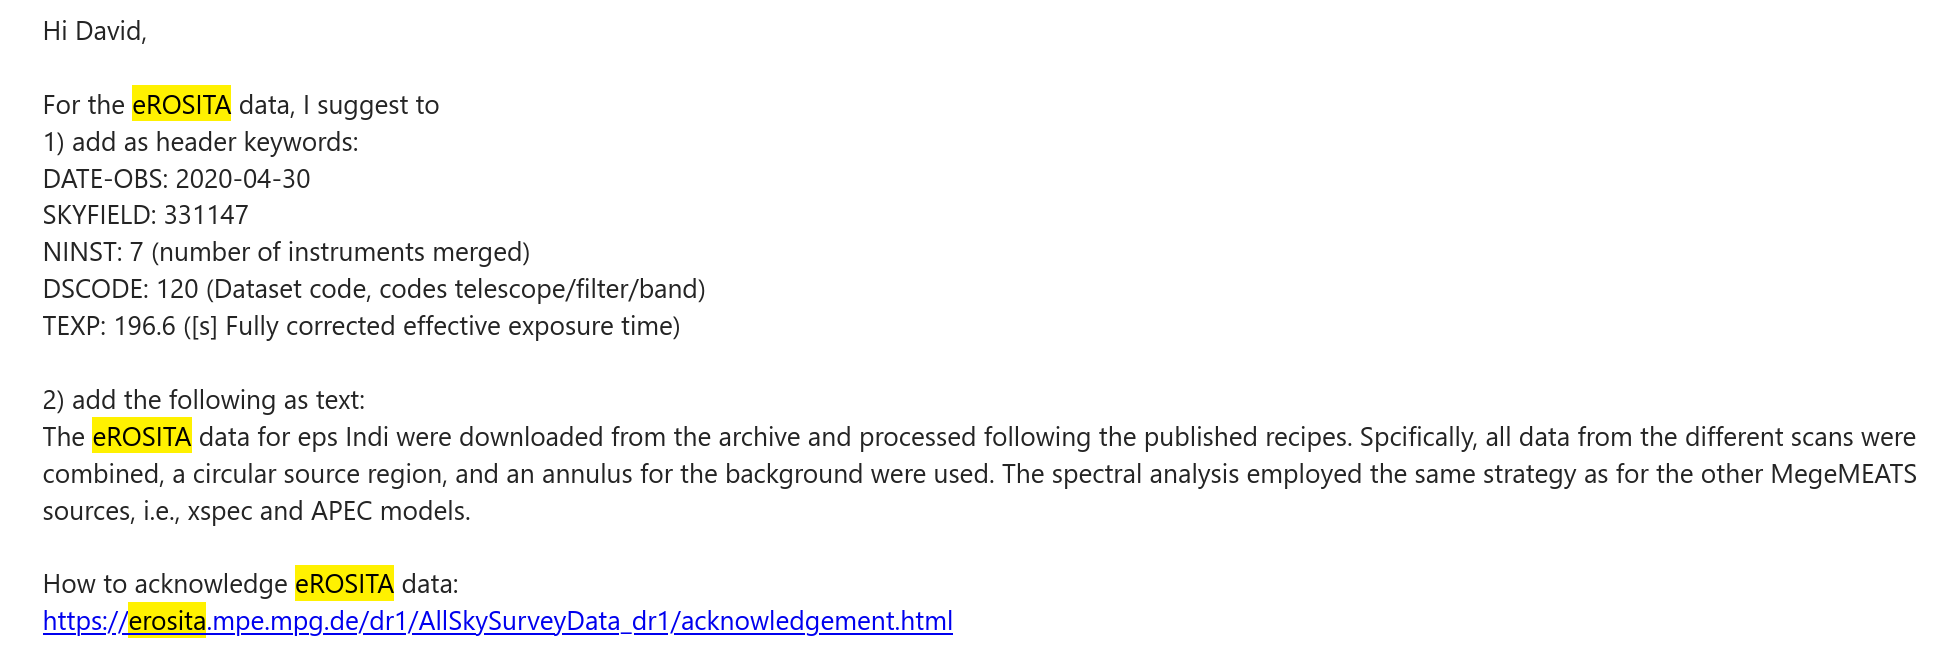

In [93]:
xpath = '/media/david/2tb_ext_hd/hddata/hwo/data/erosita/eps_ind/eps_Indi.fits'
hdul = fits.open(xpath)
print(hdul.info())
# # fig, axes = plt.subplots(nrows =2, figsize=(12, 10))
# fig, axes = plt.subplot_mosaic([[0,0,0],[0,0,0], [1,1,1]], figsize=(12, 7))
# data = hdul[1].data
# mod = hdul[2].data
# lc=hdul[3].data

# scale = 1e13

# # axes[0].errorbar(data['Wave'], data['Flux'], xerr=data['bin_width'], yerr=data['Flux_err'], ls='none')
# axes[0].errorbar(data['Wave'], data['CFlux']*scale, xerr=data['bin_width'], yerr=data['CFlux_err']*scale, ls='none', label='Data') #flux == cflux
# axes[0].step(data['Wave'], data['Mflux']*scale, where='mid', label='Model (binned)')

# axes[0].plot(mod['Wave'], mod['Flux']*scale, alpha=0.5, zorder=-1, label='Model')
# # axes[0].set_yscale('log')
# axes[0].set_ylim(-0.39, 5.39)
# axes[0].set_xlim(5.1, 69)
# axes[0].set_xlabel('Wavelength (\AA)', labelpad=-1)
# axes[0].set_ylabel('Flux (10$^{-13}$) erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
# axes[0].legend(frameon=True, loc=1)

# axes[1].errorbar(lc['Time'], lc['Rate'], yerr=lc['Error'], marker='o', markeredgecolor='k', ls='none')
# axes[1].set_ylabel('Counts (s$^{-1}$)')
# axes[1].set_xlabel('Time (s)')
# axes[1].axhline(np.median(lc['Rate']), ls='--', c='C2')
# axes[1].annotate('Median', (3364, np.median(lc['Rate'])), va='center', bbox=dict(facecolor='w', edgecolor='none', pad=5.0))
# fig.tight_layout()
# fig.subplots_adjust(hspace=0.5)

# fig.savefig('plots/eps_ind_x-ray.pdf')

Filename: /media/david/2tb_ext_hd/hddata/hwo/data/erosita/eps_ind/eps_Indi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  Obs Spectrum    1 BinTableHDU     38   195R x 10C   [E, E, E, E, E, E, E, E, E, E]   
  2  Model Spectrum    1 BinTableHDU     21   6901R x 4C   [E, E, E, E]   
  3  Light curve    1 BinTableHDU     20   6R x 3C   [E, E, E]   
None


In [94]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'eps Indi'                                                            
HIERARCH Instrument = 'EPIC    '                                                

In [95]:
hdr = hdul[0].header
hdr.append(('DATE-OBS', '2020-04-30 00:00:00'))
hdr.append(('SKYFIELD', 331147))
hdr.append(('NINST', 7))
hdr.append(('DSCODE', 120))
hdr.append(('TEXP', 196.6))
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'eps Indi'                                                            
HIERARCH Instrument = 'EPIC    '                                                
DATE-OBS= '2020-04-30 00:00:00'                                                 
SKYFIELD=               331147                                                  
NINST   =                    7                                                  
DSCODE  =                  120                                                  
TEXP    =                196.6                                                  

In [96]:
hdul.writeto('/media/david/2tb_ext_hd/hddata/hwo/data/erosita/eps_ind/eps_Indi_djw.fits', overwrite=True)


In [137]:
import prepare_erosita
importlib.reload(prepare_erosita)

xpath = '/media/david/2tb_ext_hd/hddata/hwo/data/erosita/eps_ind/eps_Indi_djw.fits'

hlsp = dict(Table.read('meats_hlsp_info.csv'))
# hlsp = np.genfromtxt('meats_hlsp_info.csv', delimiter=',', dtype=None, names=True)
# xmm_path = xpath
version = 1

prepare_erosita.make_erosita_spectra(xpath, savepath, version, hlsp, apec_repo='models/', make_apec=False, save_fits=True)

{'TELESCOP': 'eROSITA', 'INSTRUME': 'NA', 'GRATING': 'NA', 'DETECTOR': 'NA', 'FILTER': 'NA', 'SKYFIELD': 331147, 'NINST': 7, 'DSCODE': 120, 'TARGNAME': 'eps_Indi', 'RA_TARG': '', 'DEC_TARG': '', 'PROPOSID': "'16701'", 'HLSPNAME': 'MUSCLES Extension for Atmospheric Transmisson Spectroscopy', 'HLSPACRN': 'MEATS', 'HLSPLEAD': 'David J. Wilson', 'PR_INV_L': 'Youngblood', 'PR_INV_F': 'Allison', 'DATE-OBS': '2020-04-30 00:00:00', 'EXPSTART': 58969.0, 'EXPEND': 58969.0, 'EXPTIME': 196.6, 'EXPDEFN': 'MEAN', 'EXPMIN': 196.6, 'EXPMAX': 196.6, 'EXPMED': 196.6, 'NORMFAC': 1.0, 'WAVEMIN': 8.323478, 'WAVEMAX': 60.96902, 'WAVEUNIT': 'ang', 'AIRORVAC': 'vac', 'SPECRES': 15.984725, 'WAVERES': 0.13758564, 'FLUXMIN': -1.677961e-14, 'FLUXMAX': 3.362399e-13, 'FLUXUNIT': 'erg/s/cm2/ang'}
Spectrum saved as hlsp_muscles_ero_na_eps_indi_na_v1_component-spec.fits


In [106]:
# spec = fits.getdata('draft_hlsp/eps_ind/hlsp_muscles_erosita_na_eps_indi_na_v1_component-spec.fits', 1)
# names = spec.names
# for name in names[1:]:
#     # print(name)
#     fig, ax = plt.subplots()
#     ax.plot(spec['WAVELENGTH'], spec[name])
#     ax.set_ylabel(name)

Ok some bits to clean up there but it worked. Apec model  
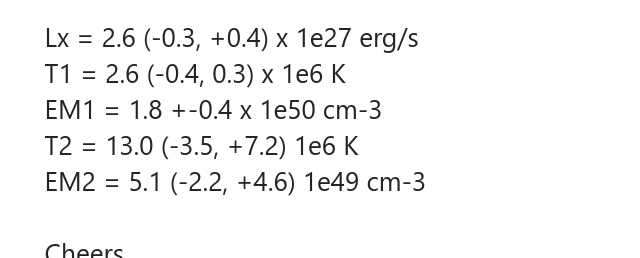

In [107]:
print((2.6e6*u.K).to(u.keV, equivalencies=u.temperature_energy()))
print((2.2e6*u.K).to(u.keV, equivalencies=u.temperature_energy()))
print((2.9e6*u.K).to(u.keV, equivalencies=u.temperature_energy()))
print((13.0e6*u.K).to(u.keV, equivalencies=u.temperature_energy()))
print((9.5e6*u.K).to(u.keV, equivalencies=u.temperature_energy()))
print((20.2e6*u.K).to(u.keV, equivalencies=u.temperature_energy()))


0.22405066481577465 keV
0.1895813317671939 keV
0.24990266460221017 keV
1.1202533240788732 keV
0.8186466599037919 keV
1.7407013189533262 keV


In [113]:
# distance = 1000/0.43
# print(distance)
# that's not right
distance = 3.6384*u.pc
lx = 2.6e27*u.erg/u.s
lx_e = [0.0, -0.3e27, 0.4e27]*u.erg/u.s
for e in lx_e:
    fx = (lx + e) / (4*np.pi*(distance.to(u.cm))**2)
    print(fx*1e14)

164.15023450134538 erg / (s cm2)
145.20982282811323 erg / (s cm2)
189.40411673232163 erg / (s cm2)


6901
5.001109 119.968254
[2.479134  0.1033475] keV


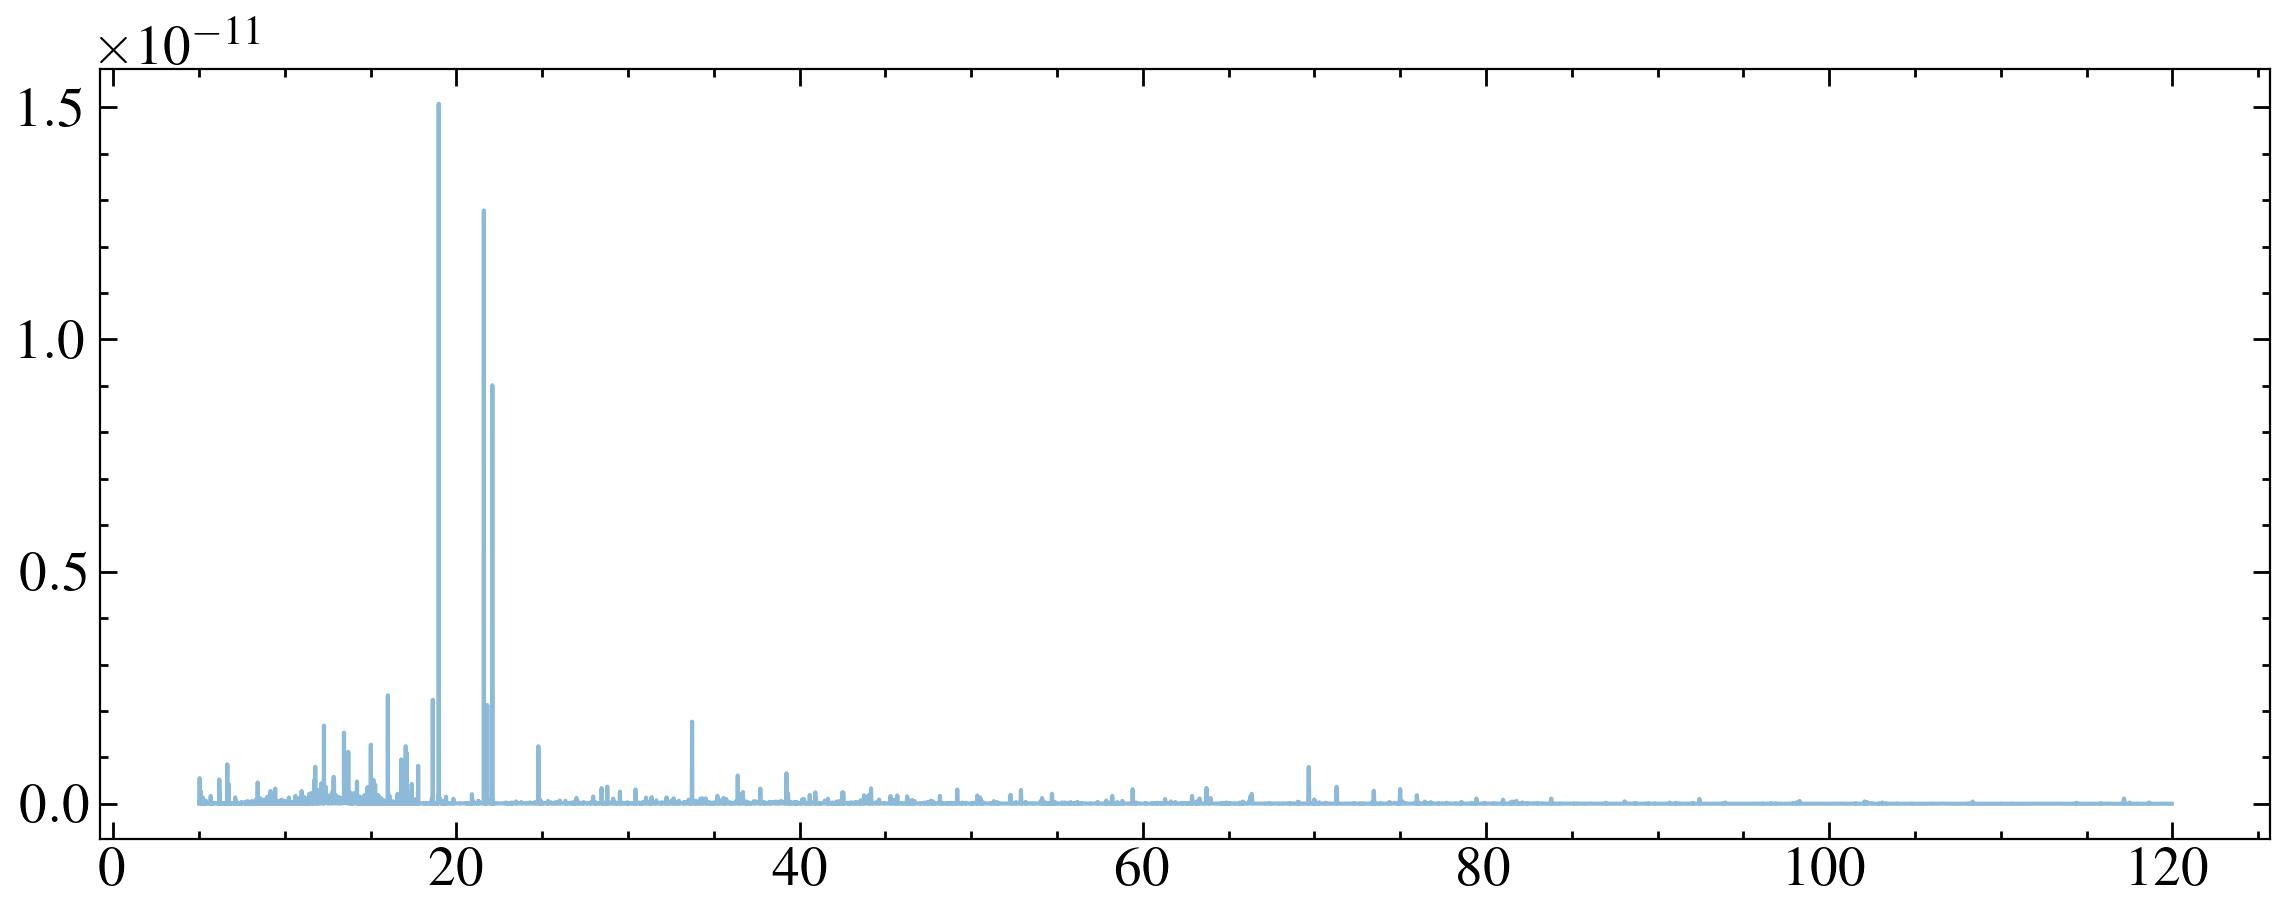

In [124]:
hdul = fits.open(xpath)

fig, ax = plt.subplots()

mod = hdul[2].data
# lc=hdul[3].data

# scale = 1e13

# # axes[0].errorbar(data['Wave'], data['Flux'], xerr=data['bin_width'], yerr=data['Flux_err'], ls='none')
# axes[0].errorbar(data['Wave'], data['CFlux']*scale, xerr=data['bin_width'], yerr=data['CFlux_err']*scale, ls='none', label='Data') #flux == cflux
# axes[0].step(data['Wave'], data['Mflux']*scale, where='mid', label='Model (binned)')

ax.plot(mod['Wave'], mod['Flux'], alpha=0.5, zorder=-1, label='Model')
# # axes[0].set_yscale('log')

print(len(mod['WAVE']))
print(mod['WAVE'][0],mod['WAVE'][-1])
engs = ([mod['WAVE'][0],mod['WAVE'][-1]]*u.AA).to(u.keV, equivalencies=u.spectral())
print(engs)

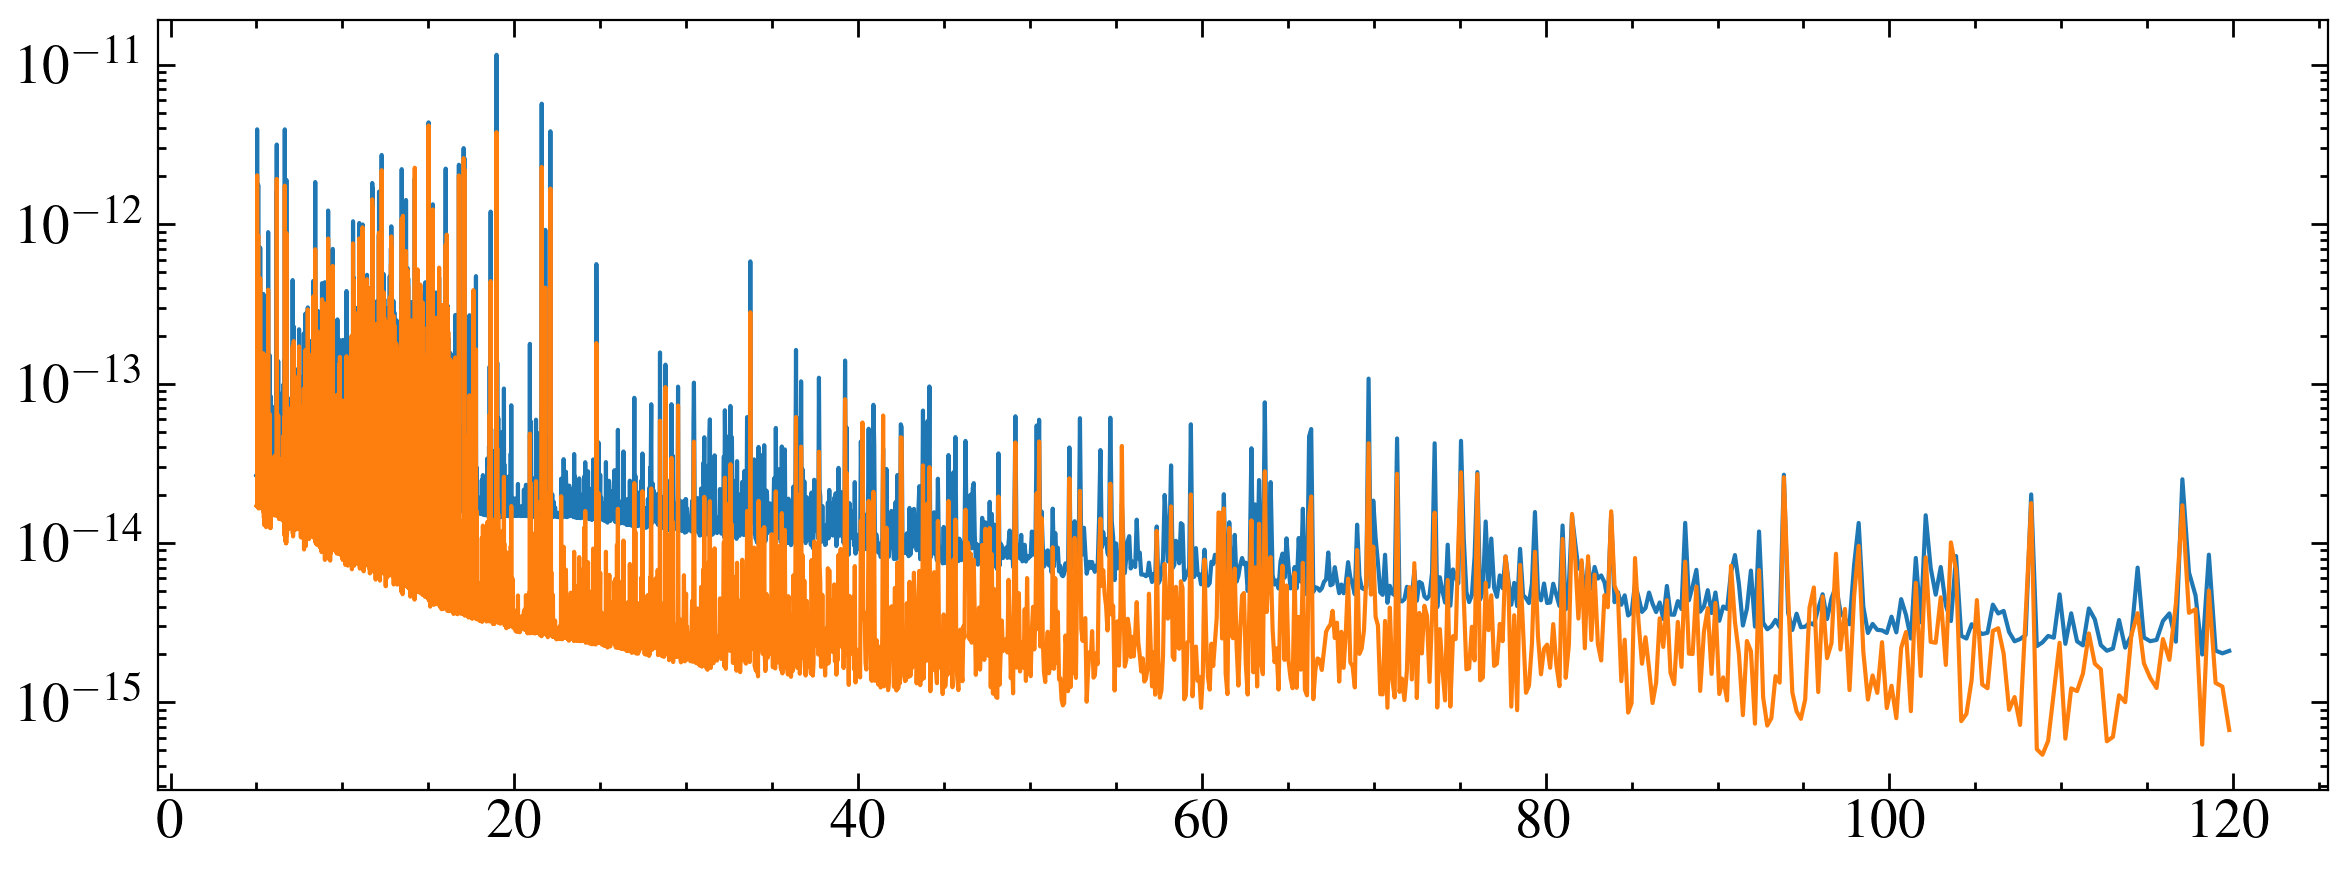

In [135]:
xray = Table.read('models/eps_Indi_apec_errs.ecsv')
fig, ax = plt.subplots()
ax.plot(xray['WAVELENGTH'], xray['FLUX'])
ax.plot(xray['WAVELENGTH'], xray['ERROR'])
ax.set_yscale('log')

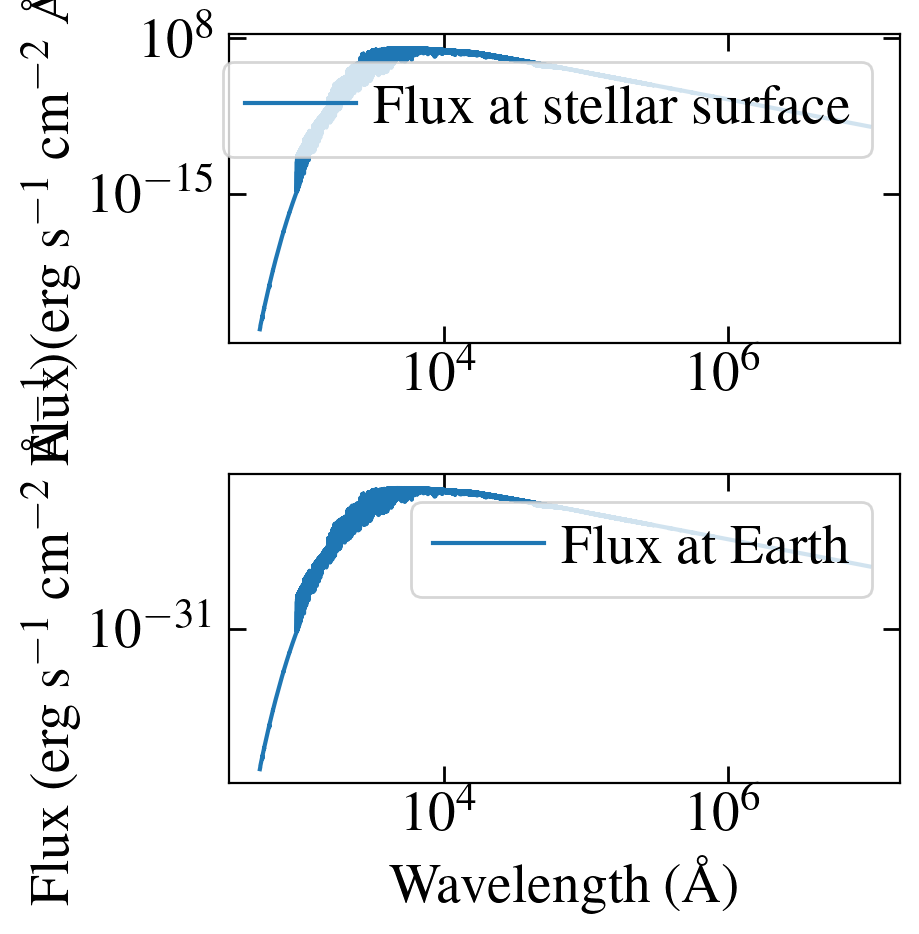

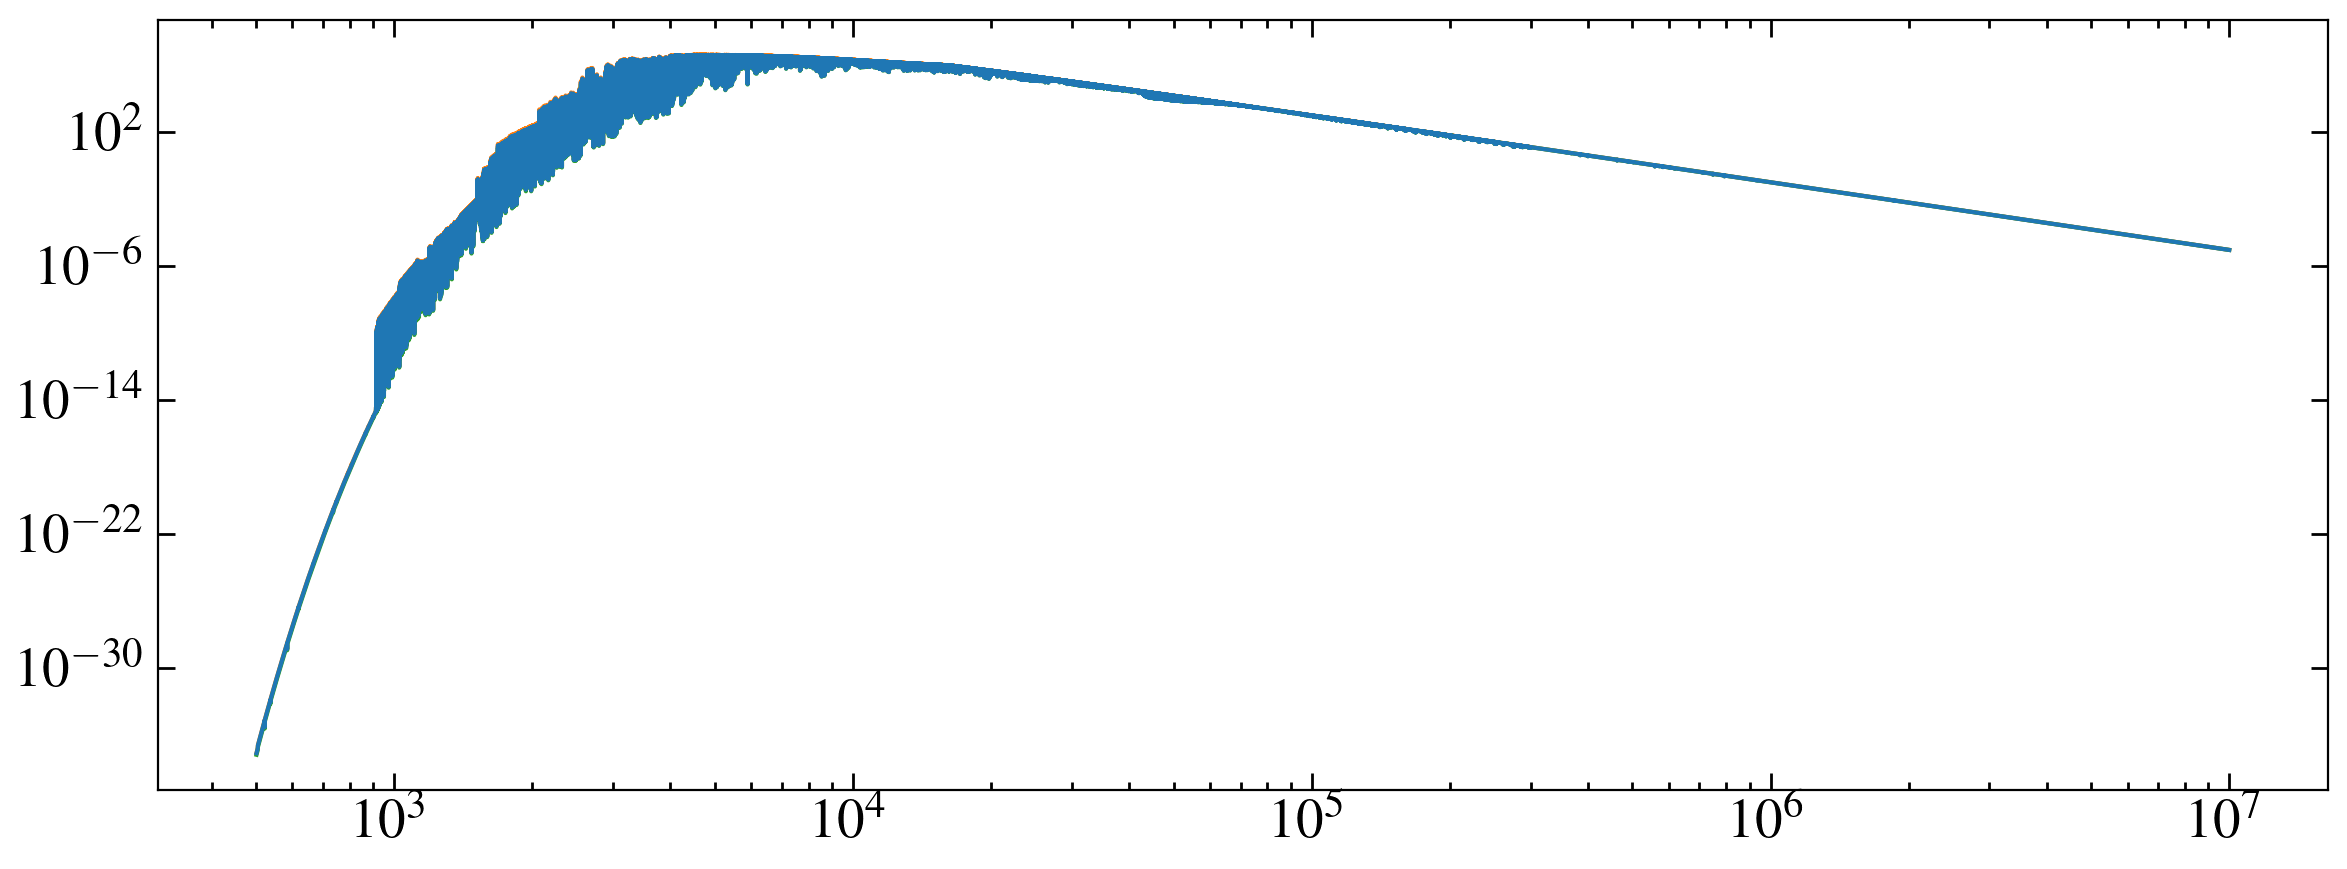

In [127]:
import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.76
teff = 4754
teff_e = 35

radius = 0.736
distance = 3.6384

save_path = 'models/'
star = 'eps_indi'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.62
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

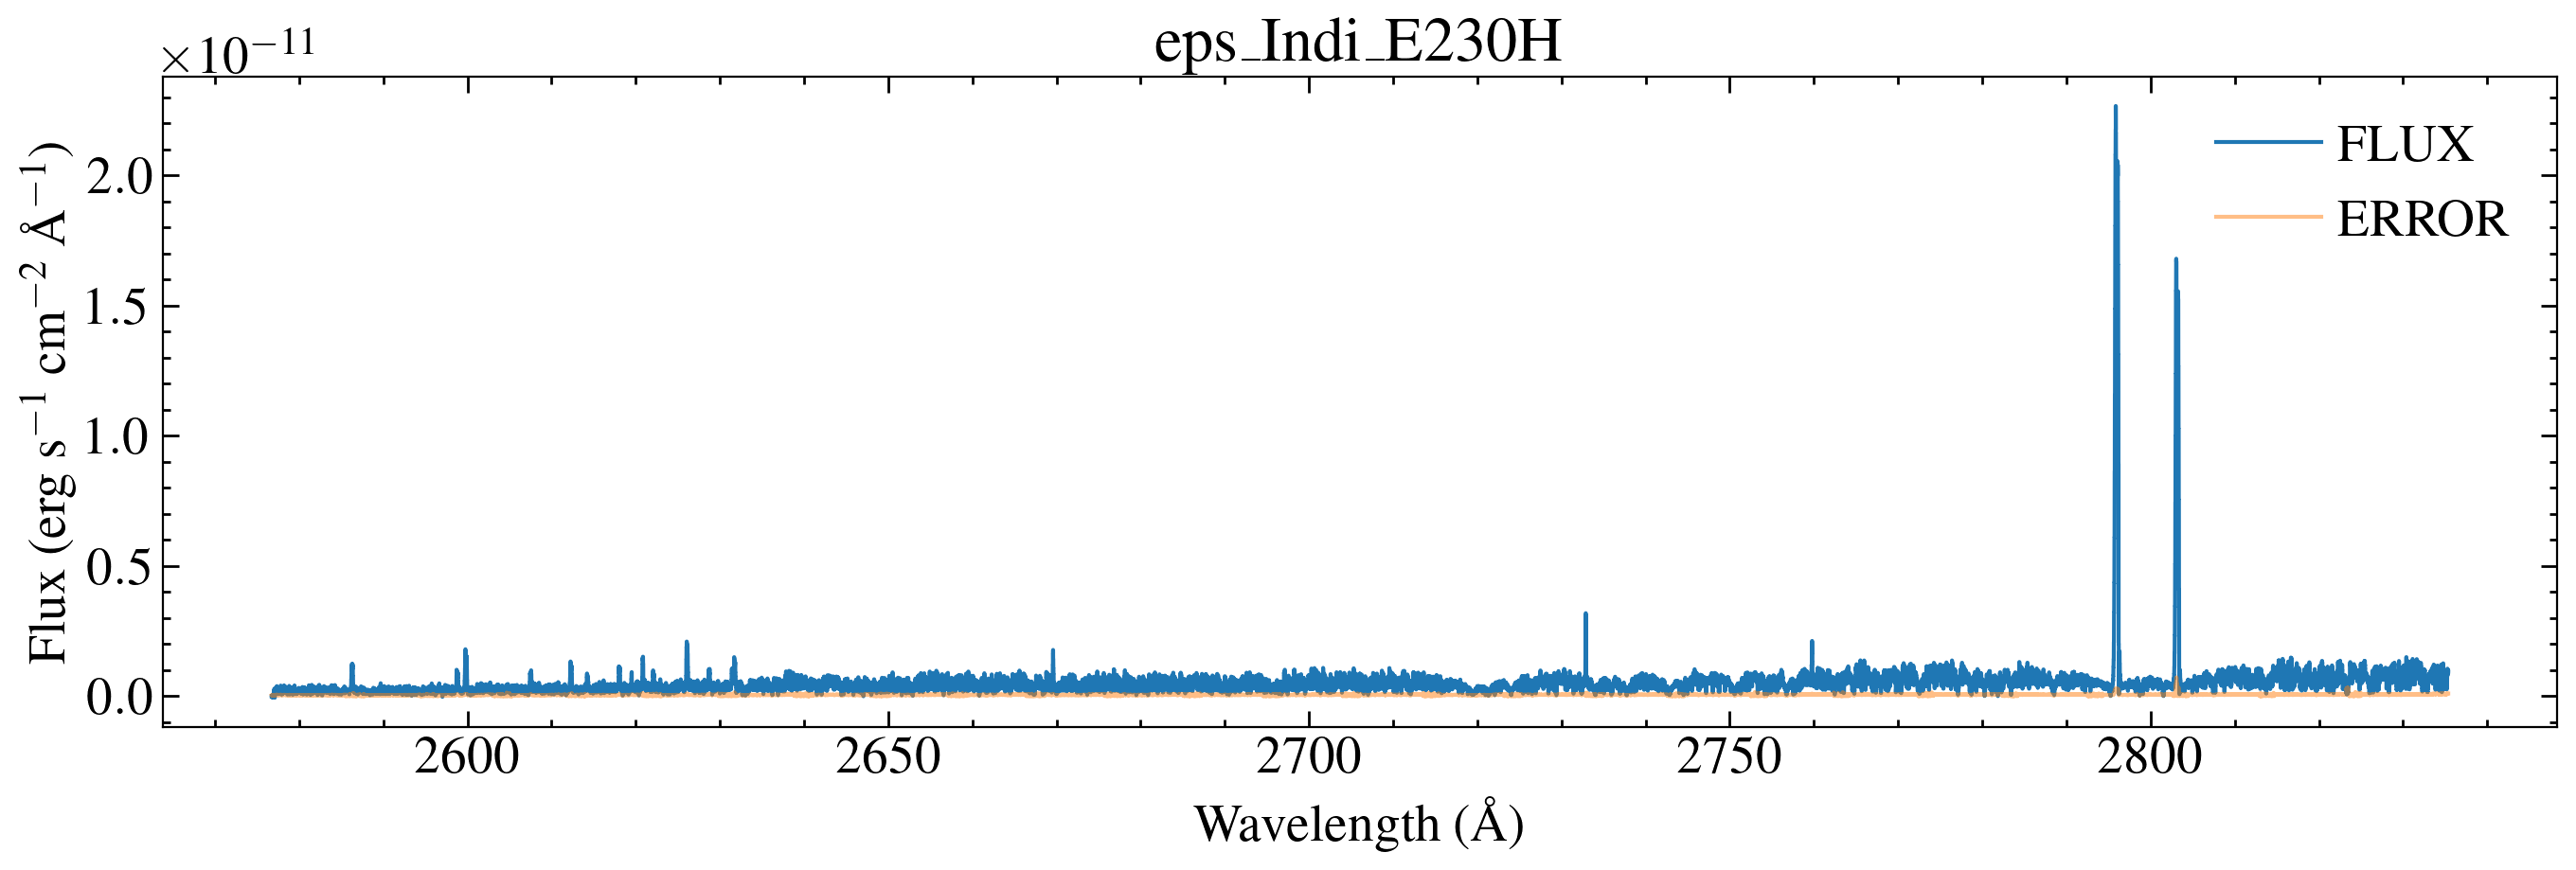

Spectrum saved as hlsp_muscles_hst_stis_eps_indi_e230h_v1_component-spec.fits


In [128]:
import prepare_stis
x1dpath = '/media/david/2tb_ext_hd/hddata/hwo/test_star/HIP-108870/hst/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'eps_Indi')


In [136]:
import prepare_model
hdr = fits.getheader('draft_hlsp/eps_ind/hlsp_muscles_hst_stis_eps_indi_e230h_v1_component-spec.fits', 0)
sed_data = Table(meta=hdr)
prepare_model.make_model_spectrum('models/eps_Indi_apec_errs.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='apec')
#PHX
prepare_model.make_model_spectrum('models/eps_indi_phoenix_interpolated.ecsv', 1, sed_data,
                                  savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')


Spectrum saved as hlsp_muscles_model_apec_eps_indi_na_v1_component-spec.fits
Spectrum saved as hlsp_muscles_model_phx_eps_indi_na_v1_component-spec.fits


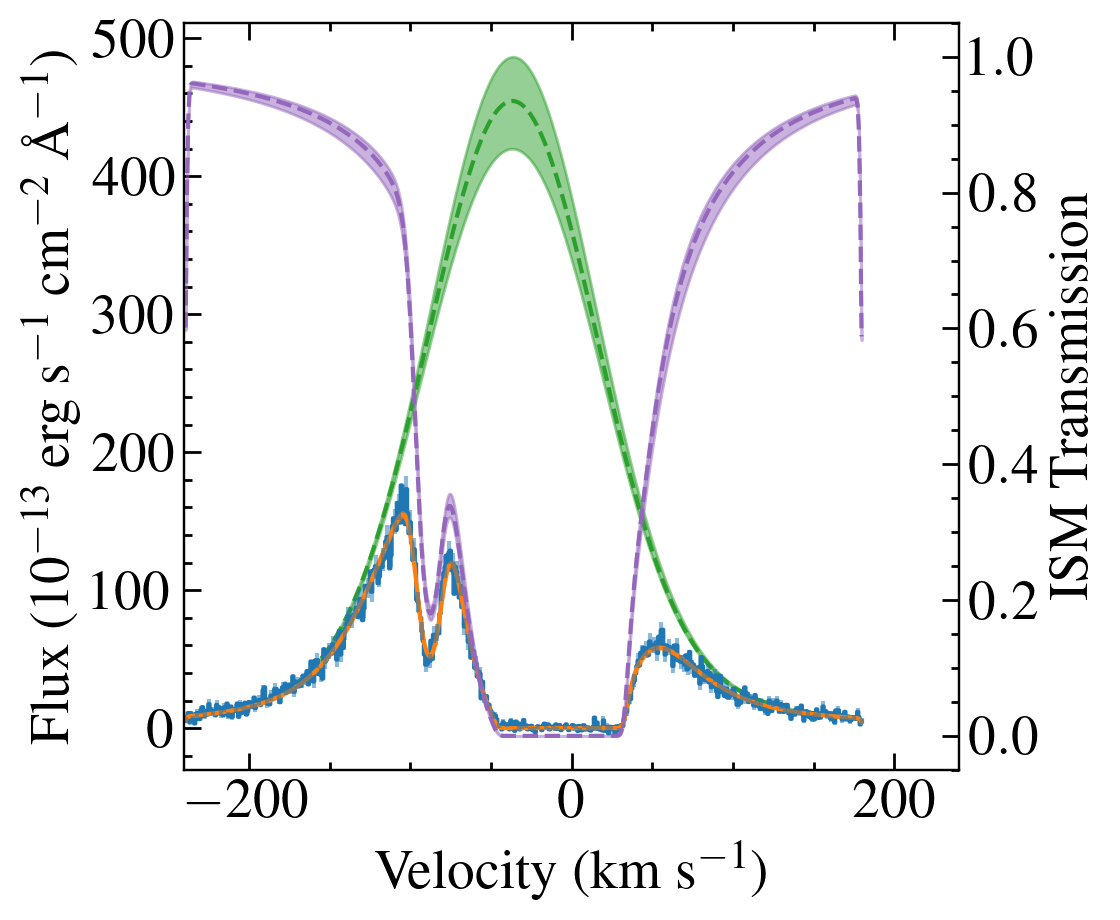

In [130]:
lyapath = '/home/david/work/hwo/HD209100_MCMC_results.csv'
data = Table.read(lyapath)
# data.dtype.names


lya = 1215.67
ism_scale = 2.3e-13 #scaling ism to plot
fscale = 1e13 #scaling flux to axis
ism_scale *= fscale

fig, ax= plt.subplots(figsize=(6,5))
v = (data['wave_lya']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
ax.step(v, data['flux_lya']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
ax.errorbar(v, data['flux_lya']*fscale, yerr=data['error_lya']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
ax.plot(v, data['lya_model_median']*fscale, c='C1', label='Model fit', zorder=1)
ax.fill_between(v.value, data['lya_model_high_1sig']*fscale,data['lya_model_low_1sig']*fscale, color='C1', alpha=0.5)

ax.plot(v, data['lya_intrinsic_median']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
ax.fill_between(v.value, data['lya_intrinsic_high_1sig']*fscale,data['lya_intrinsic_low_1sig']*fscale, color='C2', alpha=0.5, zorder=-10)

# name = os.path.split(spec)[1][:-34]
# ax.set_title(name, size=20)

# xlim = min([abs(min(v.value)), max(v.value)])-10
xlim = 240
ax.set_xlim(-xlim, xlim)
ax2=ax.twinx()
ax2.plot(v, data['lya_ism_median'], c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
ax2.fill_between(v.value, data['lya_ism_high_1sig'],data['lya_ism_low_1sig'], color='C4', alpha=0.5, zorder=-10)
ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel('ISM Transmission')


ax.set_xlabel('Velocity (km s$^{-1}$)', size=20)
ax.set_ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)

fig.tight_layout()

# fig.savefig('plots/toi-776_lya.pdf')

In [132]:
lw, lf, le = data['wave_lya'], data['lya_intrinsic_median'], np.mean([data['lya_intrinsic_high_1sig']-data['lya_intrinsic_median'], data['lya_intrinsic_median']-data['lya_intrinsic_low_1sig']], axis=0)
lyatab = Table([lw, lf, le], names=['WAVELENGTH', 'FLUX', 'ERROR'])
lyatab.write('models/eps_indi_lya.ecsv', overwrite=True)

prepare_model.make_model_spectrum('models/eps_indi_lya.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='lya')


Spectrum saved as hlsp_muscles_model_lya_eps_indi_na_v1_component-spec.fits


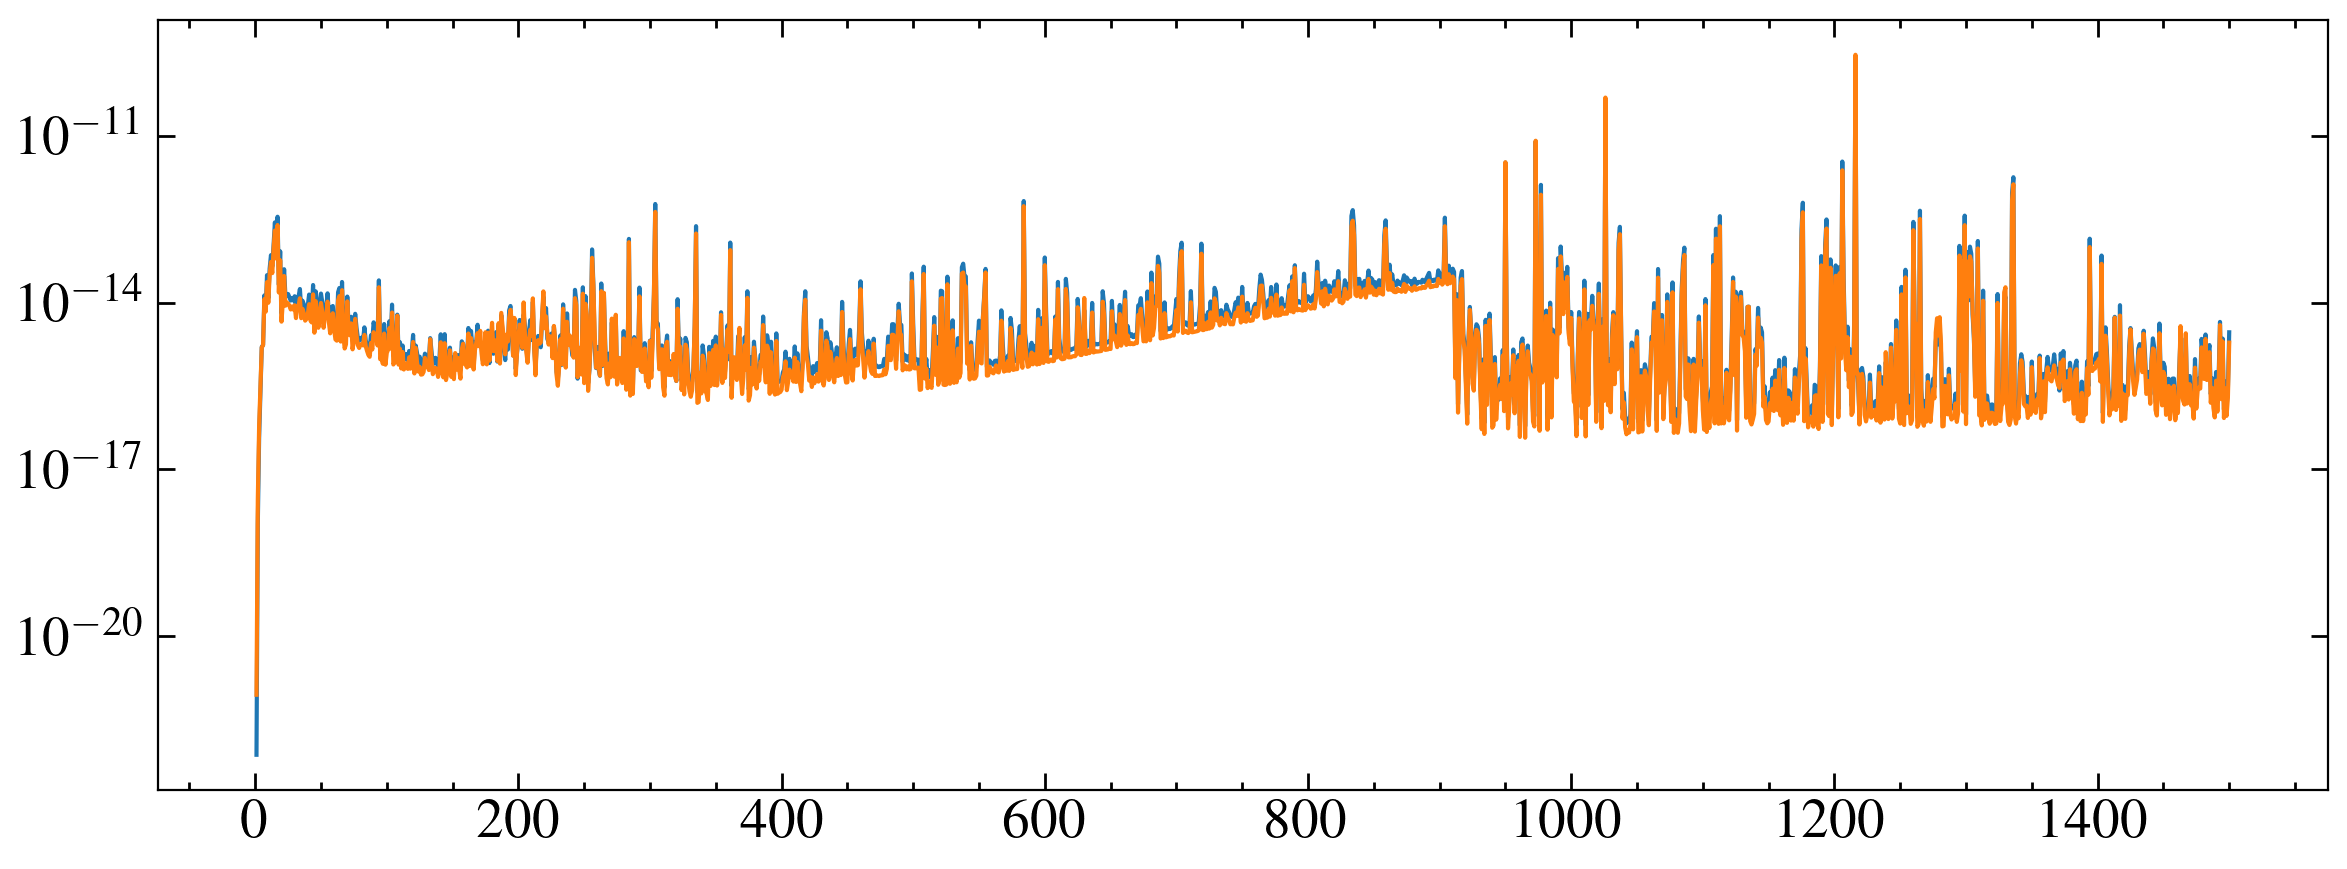

In [133]:
#dem 
dempath = '/media/david/2tb_ext_hd/hddata/meats/dems/eps_indi/spectrum_eps_ind_p17.fits'
dem = fits.getdata(dempath, 1)

dw, df= dem['Wavelength'], dem['Flux_density']
eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']


mean_e = np.mean([eu, el], axis=0)
# plt.plot(dw, mean_e)
# plt.yscale('log')

log_mean_e = (eu - el) / (np.log(eu)- np.log(el))

plt.plot(dw, df)
plt.plot(dw, log_mean_e)
# plt.plot(dw, mean_e)

plt.yscale('log')

demtab = Table([dw, df, log_mean_e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
demtab.write('models/eps_indi_dem.ecsv', overwrite=True)



In [134]:
prepare_model.make_model_spectrum('models/eps_indi_dem.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='dem')

Spectrum saved as hlsp_muscles_model_dem_eps_indi_na_v1_component-spec.fits


In [173]:
starspec = fits.getdata('fixed_hlsp/eps_indi/hlsp_muscles_multi_multi_eps_indi_broadband_v25_adapt-const-res-sed.fits', 1)
starw, starf = starspec['WAVELENGTH'], starspec['FLUX']
sol = Table.read('Solar_1au_sed.ecsv')
sw, sf = sol['WAVELENGTH'], sol['FLUX']

In [172]:
len(starf[starf < 0])

0

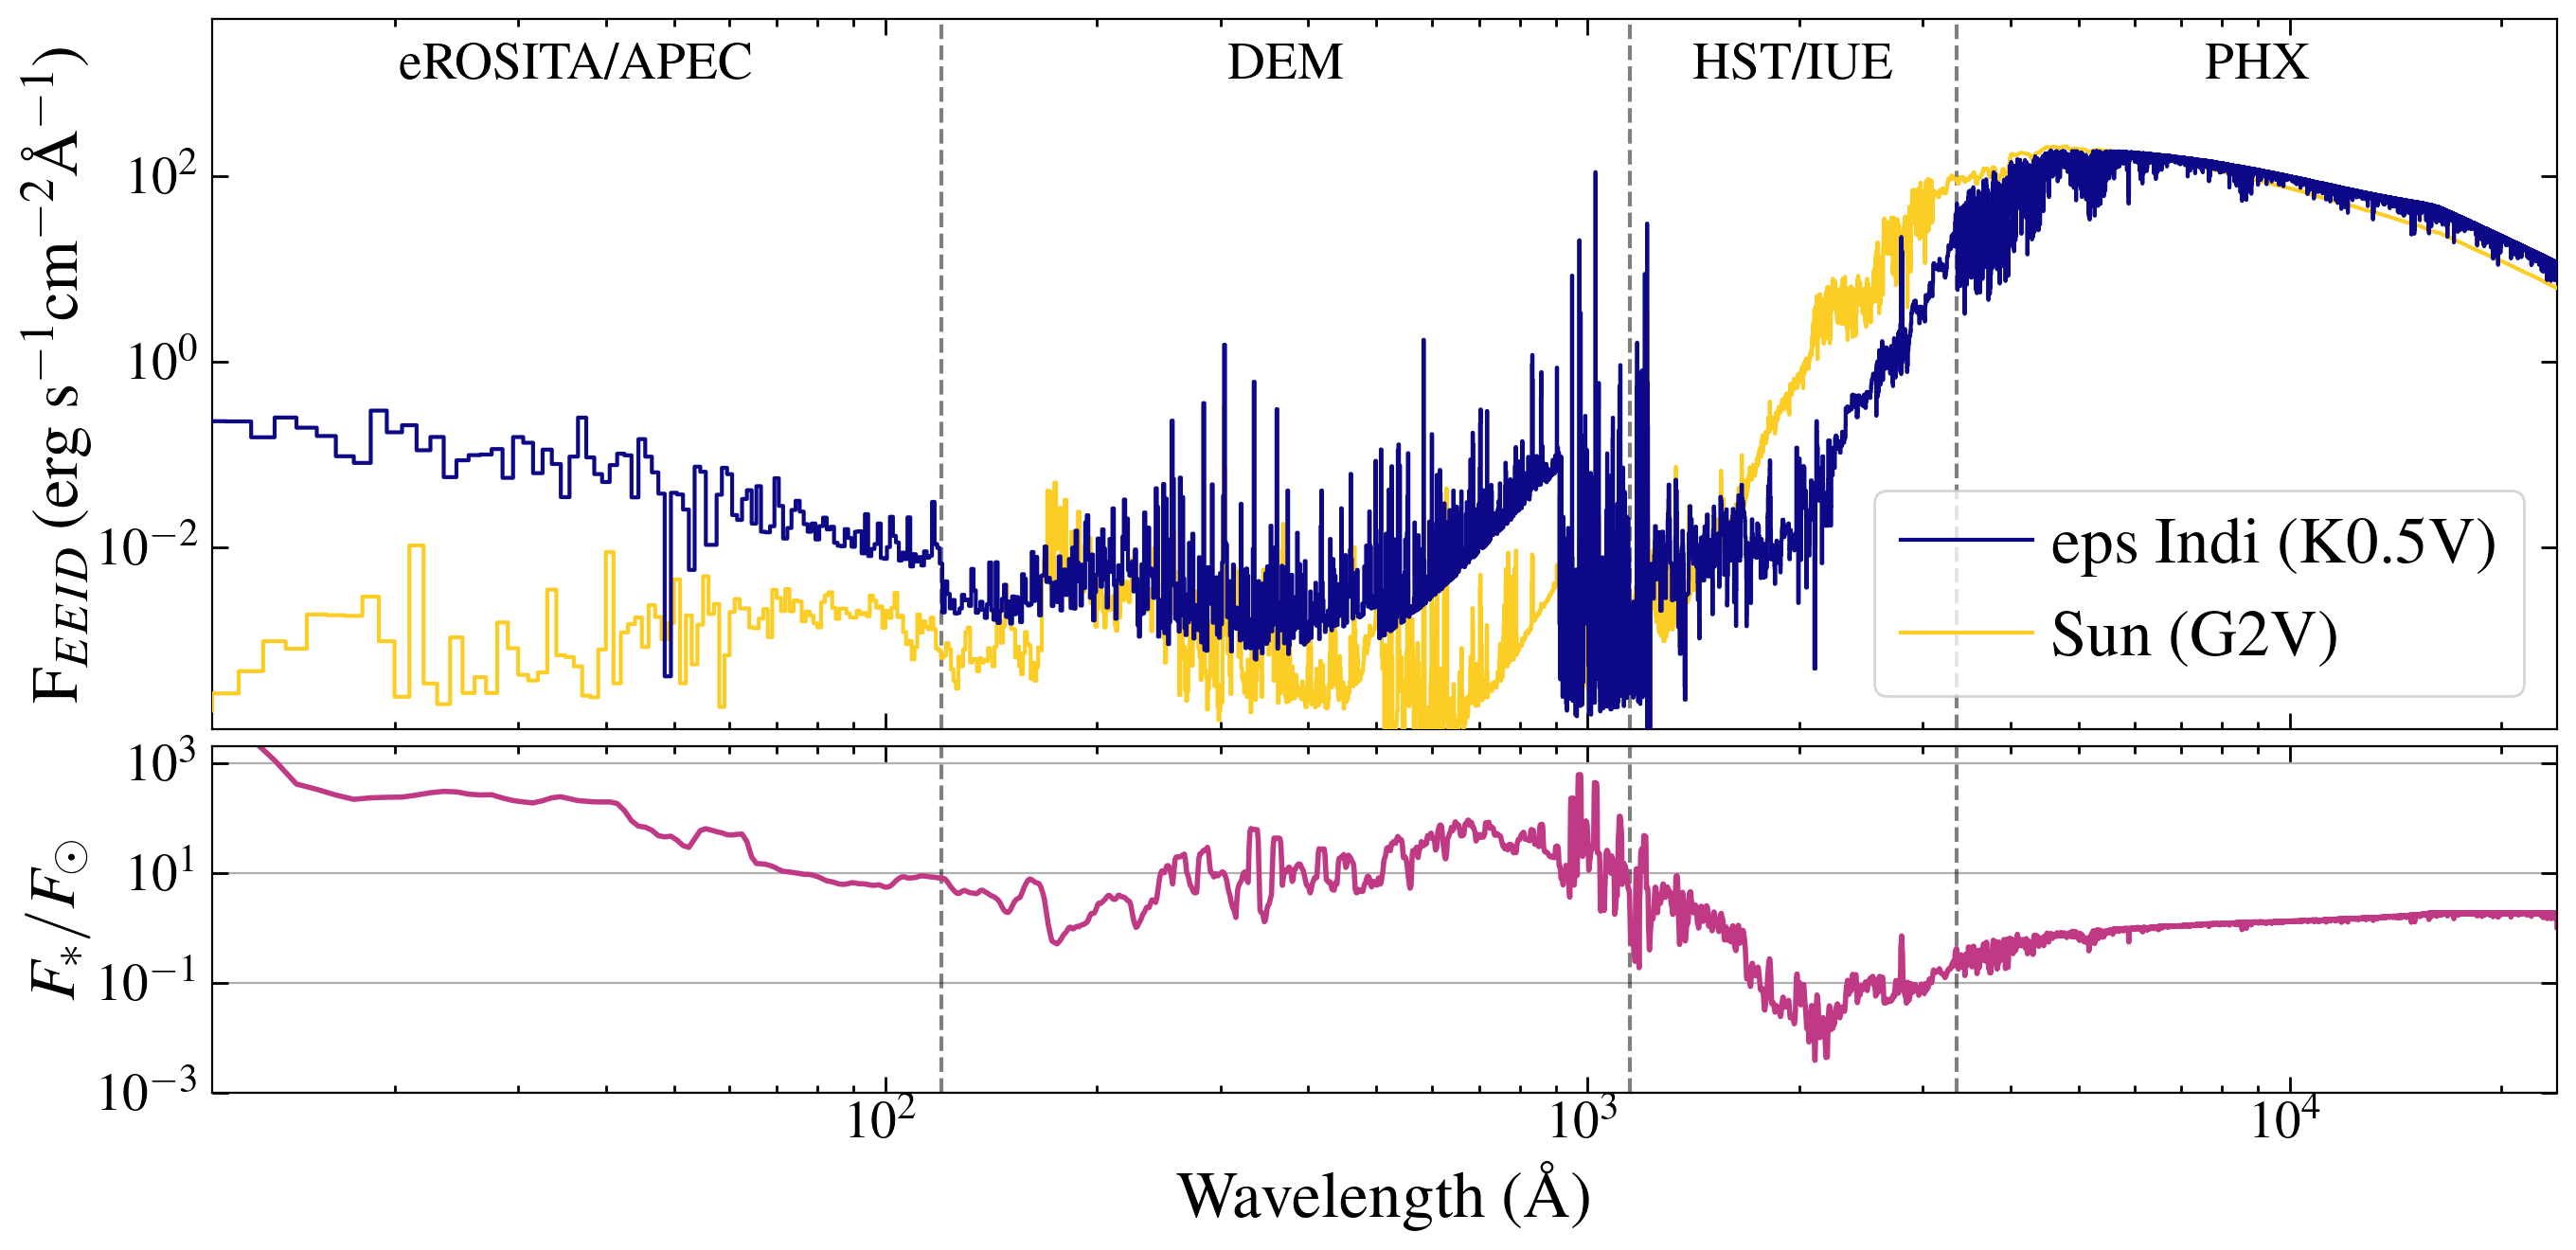

In [174]:

# cols = ['C0', 'C1', 'C2']
cols = [plt.cm.plasma(0),plt.cm.plasma(0.9), plt.cm.plasma(0.45)]

dstar = 3.6384*u.pc
dsun = 1*u.au
lstar = 10**-0.6540
eeidau = 0.471*u.au
# eeidau = (lstar**0.5)*1*u.au

solscale = lstar*(dsun.to(u.m)/dstar.to(u.m))**2
starscale = ((dstar.to(u.m))/(eeidau.to(u.m)))**2

fig, axes = plt.subplot_mosaic([[0,0,0],[0,0,0],[1,1,1]],figsize=(14, 7), sharex=True)


ax= axes[0]
ax.step(starw, starf*starscale, c=cols[0], label = 'eps Indi (K0.5V)', zorder=12, where='mid')
ax.step(sw, sf, c=cols[1], label = 'Sun (G2V)', zorder=10, where='mid')
# ax.set_xlim(11, sw[-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.1e-4, 4.9e3)

bar_y = 1e3
label_y = bar_y*1.5
e_y = bar_y *0.3

xlims = (11, sw[-1])
ax.set_xlim(xlims[0], xlims[1])
divlines = (120, 1150, 3350)
[ax.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]

labels = ['eROSITA/APEC', 'DEM', 'HST/IUE', 'PHX']
labpos = np.sort(np.hstack((xlims, divlines)))

for i, label in enumerate(labels):
    label_x = (labpos[i]*labpos[i+1])**0.5
    ax.annotate(label, (label_x, label_y), ha='center', va='center')



ax.legend(fontsize=25, loc=4,frameon=True)
ax.set_ylabel('F$_{EEID}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)

ax1 = axes[1]
ax1.set_xlabel('Wavelength (\AA)', size=25)
[ax1.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]


mask = (starw> sw[0]) & (starw < sw[-1])
fnew = interp1d(starw[mask], starf[mask], fill_value='extrapolate')(sw)
fnew = fnew*starscale.value
ratio = fnew/sf
ratio = convolve(ratio,Box1DKernel(10))
ax1.plot(sw, ratio, c=cols[2], lw=2)
# ax1.set_ylim(0, 1000)

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 2e3)
ax1.set_ylabel('$F_*/F_{\odot}$', size=25)
# ax1.axhline(1, ls='--', c='k', alpha=0.5)

ax1.grid(axis='y')
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


# plt.savefig('plots/eps_ind_v_sun.pdf')

# add the old eps_ind spec
# data = Table.read('/home/david/work/hwo/seds/eps_ind_sed_v01.txt', format='ascii.basic')
# oldw, oldf = np.loadtxt('/home/david/work/hwo/seds/eps_ind_sed_v01.txt', unpack=True)
# ax.step(oldw, oldf*starscale, c='C2', zorder=20)

(8, 49000.0)

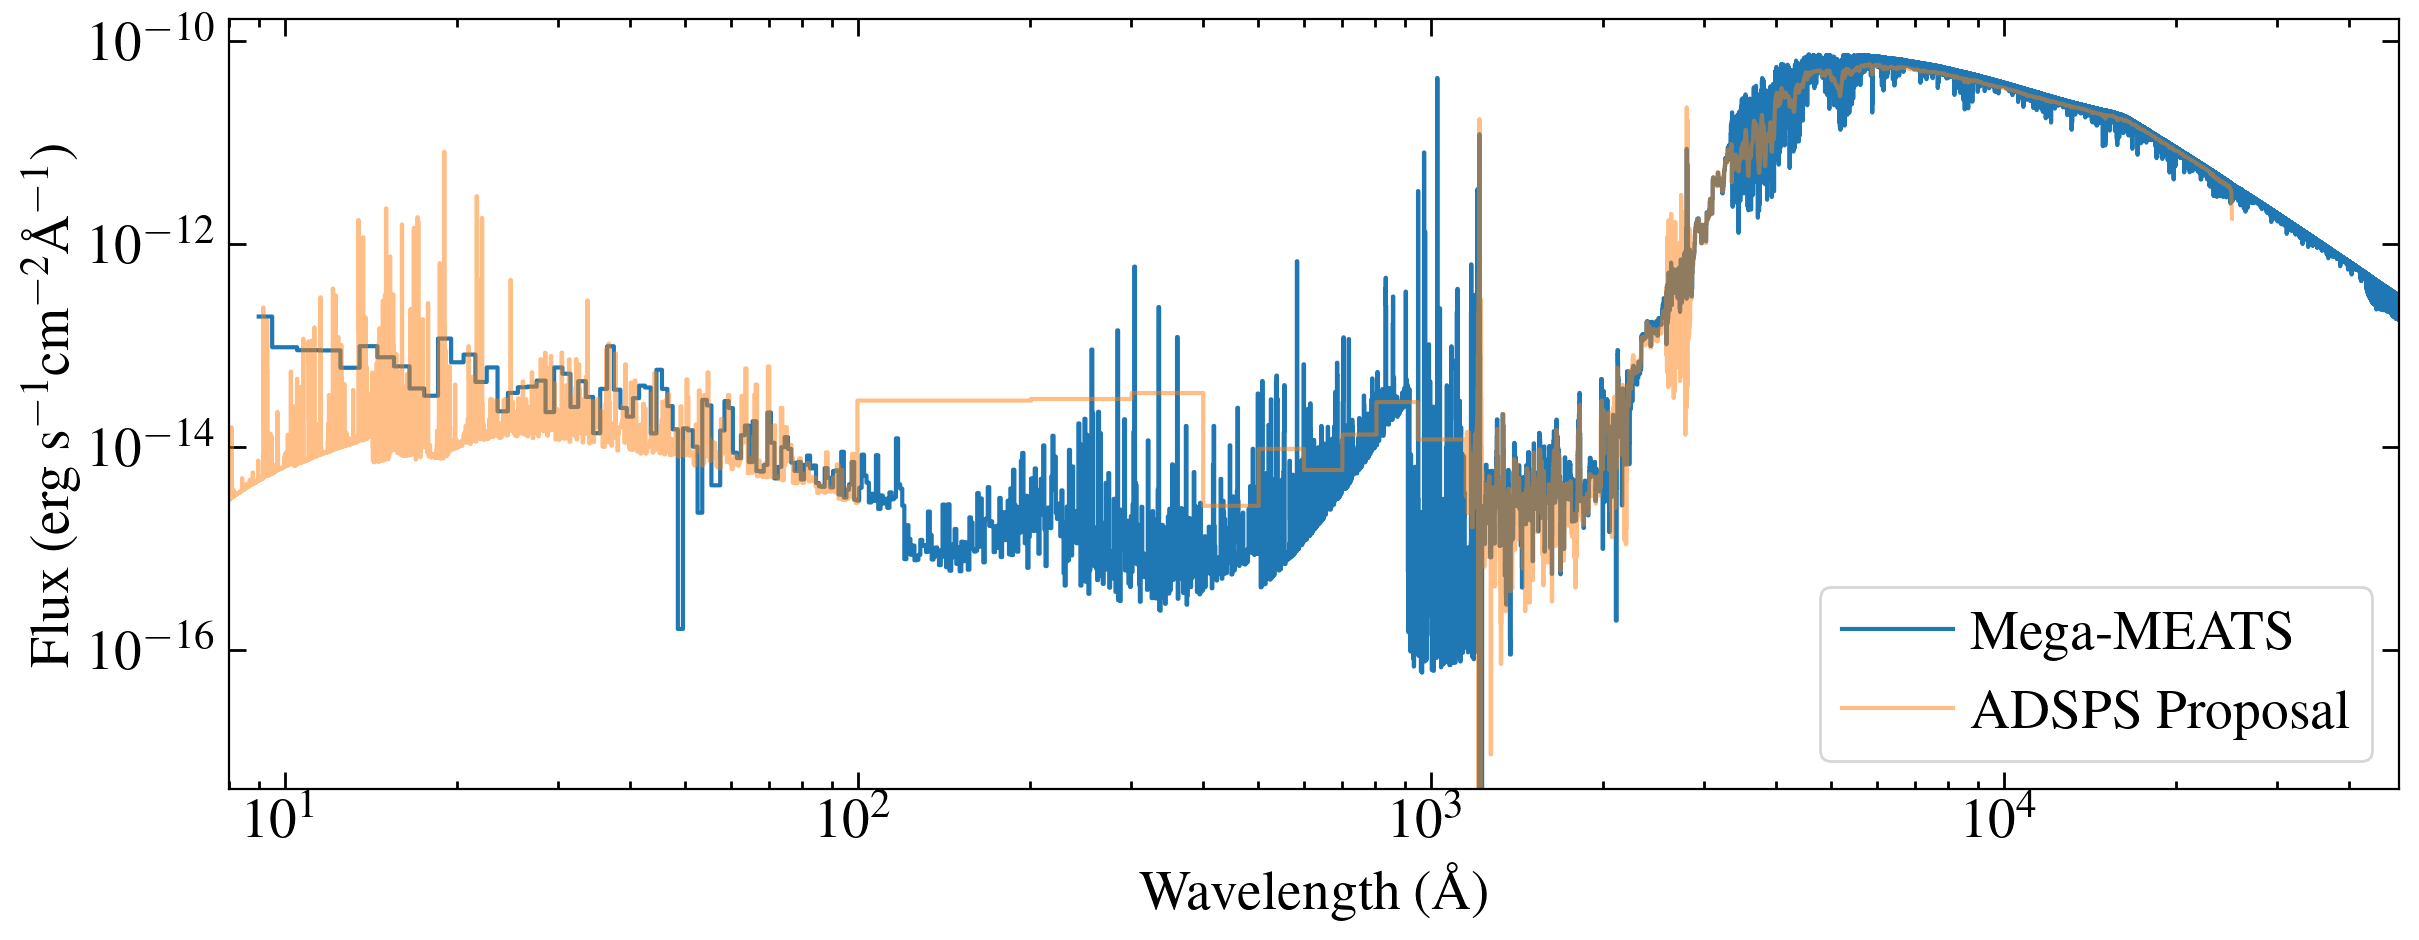

In [166]:
fig, ax = plt.subplots()

ax.step(starw, starf, label = 'Mega-MEATS', where='mid')
ax.step(oldw, oldf, where='mid', alpha=0.5, label='ADSPS Proposal')

ax.set_yscale('log')
ax.set_xscale('log')


ax.set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')

ax.set_xlabel('Wavelength (\AA)')
ax.legend(frameon=True, loc=4)

ax.set_xlim(8, 4.9e4)